In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def naca_00xx_thickness(x, t=0.12):
    """
    Half-thickness distribution for a NACA 4-digit symmetric airfoil
    x: chordwise coordinate normalised by chord (0..1)
    t: thickness ratio (NACA 0012 -> t=0.12)
    Returns: y_t(x) half thickness
    """
    x = np.clip(x, 0, 1)  # safety
    yt = 5*t*(0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)
    return yt

def naca0012_coordinates(n_points=200): #Generate upper and lower surface coordinates for NACA 0012 using cosine spacing (this gives more points near the leading edge where curvature is highest)

    beta = np.linspace(0, np.pi, n_points)
    x = 0.5*(1 - np.cos(beta))   #cosine spacing from 0..1

    yt = naca_00xx_thickness(x, t=0.12)
    x_upper, y_upper = x,  yt
    x_lower, y_lower = x, -yt

    return x_upper, y_upper, x_lower, y_lower

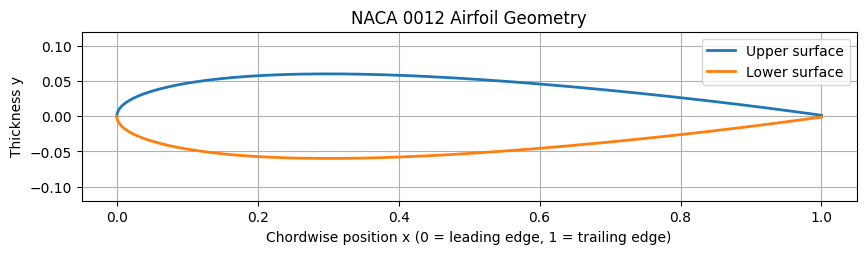

In [ ]:
x_u, y_u, x_l, y_l = naca0012_coordinates(n_points=200)

plt.figure(figsize=(10, 5))

plt.plot(x_u, y_u, linewidth=2, label="Upper surface")
plt.plot(x_l, y_l, linewidth=2, label="Lower surface")

ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

# Add vertical padding so it doesn't look squashed
y_max = max(abs(y_u).max(), abs(y_l).max())
ax.set_ylim(-2*y_max, 2*y_max)

plt.xlabel("Chordwise position x (0 = leading edge, 1 = trailing edge)")
plt.ylabel("Thickness y")
plt.title("NACA 0012 Airfoil Geometry")

plt.grid(True)
plt.legend()

plt.show()


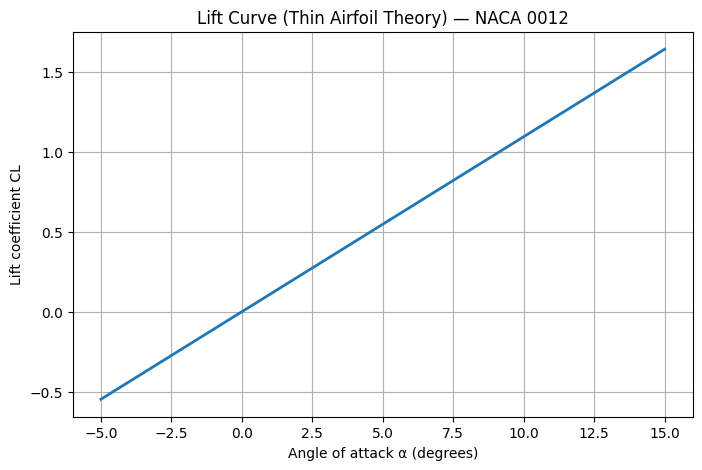

In [ ]:
def CL_thin_airfoil(alpha_deg):
    """
    Thin airfoil theory:
    CL = 2*pi*alpha  (alpha in radians)
    """
    alpha_rad = np.deg2rad(alpha_deg)
    return 2*np.pi*alpha_rad

alphas = np.linspace(-5, 15)
CLs = CL_thin_airfoil(alphas)

plt.figure(figsize=(8, 5))
plt.plot(alphas, CLs, linewidth=2)
plt.xlabel("Angle of attack α (degrees)")
plt.ylabel("Lift coefficient CL")
plt.title("Lift Curve (Thin Airfoil Theory) — NACA 0012")
plt.grid(True)
plt.show()

In [179]:
def Cp_distribution_low_fidelity(x, alpha_deg): #Low-fidelity Cp model for a symmetric airfoil at small angles of attack
    """
    Designed to look physically plausible:
    - mild leading-edge suction peak
    - recovery toward trailing edge
    - upper/lower separation increases with AoA
    """
    alpha = np.deg2rad(alpha_deg)

    #Smooth suction shape (bounded): high near LE, decays downstream
    #avoids the extreme 1/sqrt(x) singularity
    suction_shape = np.exp(-4*x) * (1 + 3*(1 - x))

    #Scale with AoA (tuned for realistic Cp range)
    strength = 1.2 * alpha

    #Baseline + AoA-induced delta
    delta = strength * suction_shape

    #Cp definition from a "velocity-like" model, but bounded
    Cp_upper = 1 - (1 + 2.0*delta)**2
    Cp_lower = 1 - (1 - 2.0*delta)**2

    #Mild recovery (optional)
    recovery = 0.08*(1 - x)
    Cp_upper += recovery
    Cp_lower += recovery

    return Cp_upper, Cp_lower

def CL_from_pressure(x, Cp_upper, Cp_lower):

    #CL = integral_0^1 (Cp_lower - Cp_upper) dx

    return np.trapezoid(Cp_lower - Cp_upper, x)

AoA = 5°
CL from pressure integration (model) = 0.680
CL from thin airfoil theory          = 0.548


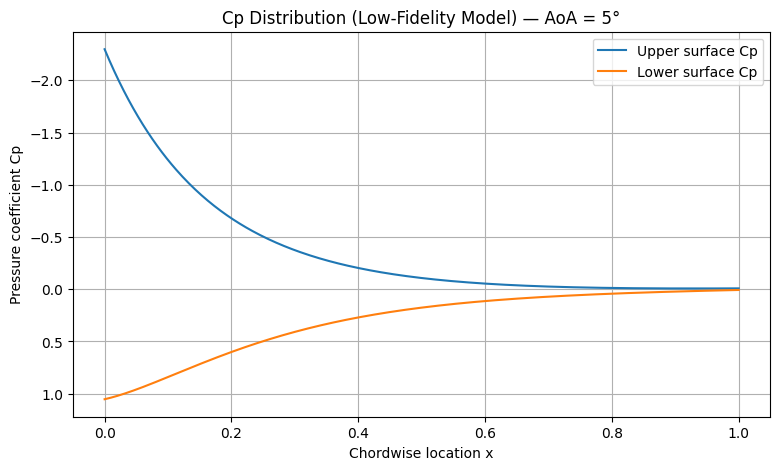

In [ ]:
x = np.linspace(0, 1, 400)
alpha_test = 5

Cp_u, Cp_l = Cp_distribution_low_fidelity(x, alpha_test)
CL_pressure = CL_from_pressure(x, Cp_u, Cp_l)
CL_theory = CL_thin_airfoil(alpha_test)

print(f"AoA = {alpha_test}°")
print(f"CL from pressure integration (model) = {CL_pressure:.3f}")
print(f"CL from thin airfoil theory          = {CL_theory:.3f}")

plt.figure(figsize=(9, 5))
plt.plot(x, Cp_u, label="Upper surface Cp")
plt.plot(x, Cp_l, label="Lower surface Cp")
plt.gca().invert_yaxis()
plt.xlabel("Chordwise location x")
plt.ylabel("Pressure coefficient Cp")
plt.title(f"Cp Distribution (Low-Fidelity Model) — AoA = {alpha_test}°")
plt.grid(True)
plt.legend()
plt.show()

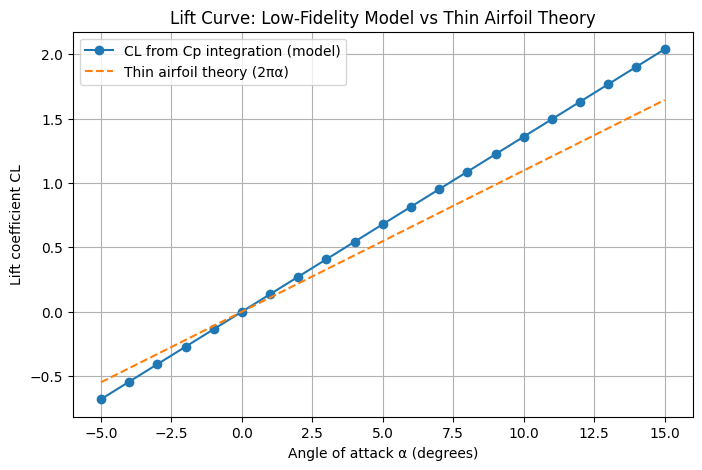

In [ ]:
alphas = np.linspace(-5, 15, 21)

CL_model = []
for a in alphas:
    Cpu, Cpl = Cp_distribution_low_fidelity(x, a)
    CL_model.append(CL_from_pressure(x, Cpu, Cpl))

CL_model = np.array(CL_model)
CL_theory_curve = CL_thin_airfoil(alphas)

plt.figure(figsize=(8, 5))
plt.plot(alphas, CL_model, marker="o", label="CL from Cp integration (model)")
plt.plot(alphas, CL_theory_curve, linestyle="--", label="Thin airfoil theory (2πα)")
plt.xlabel("Angle of attack α (degrees)")
plt.ylabel("Lift coefficient CL")
plt.title("Lift Curve: Low-Fidelity Model vs Thin Airfoil Theory")
plt.grid(True)
plt.legend()
plt.show()

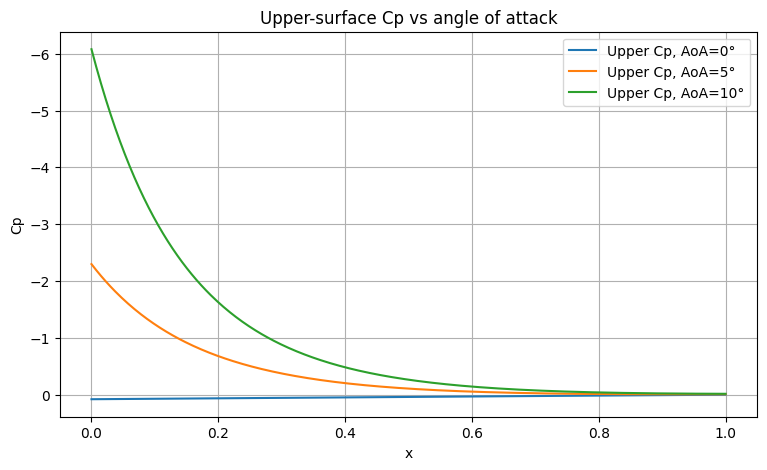

In [ ]:
x = np.linspace(0, 1, 400)
angles = [0, 5, 10]

plt.figure(figsize=(9,5))
for a in angles:
    Cpu, Cpl = Cp_distribution_low_fidelity(x, a)
    plt.plot(x, Cpu, label=f"Upper Cp, AoA={a}°")
plt.gca().invert_yaxis()
plt.xlabel("x")
plt.ylabel("Cp")
plt.title("Upper-surface Cp vs angle of attack")
plt.grid(True)
plt.legend()
plt.show()

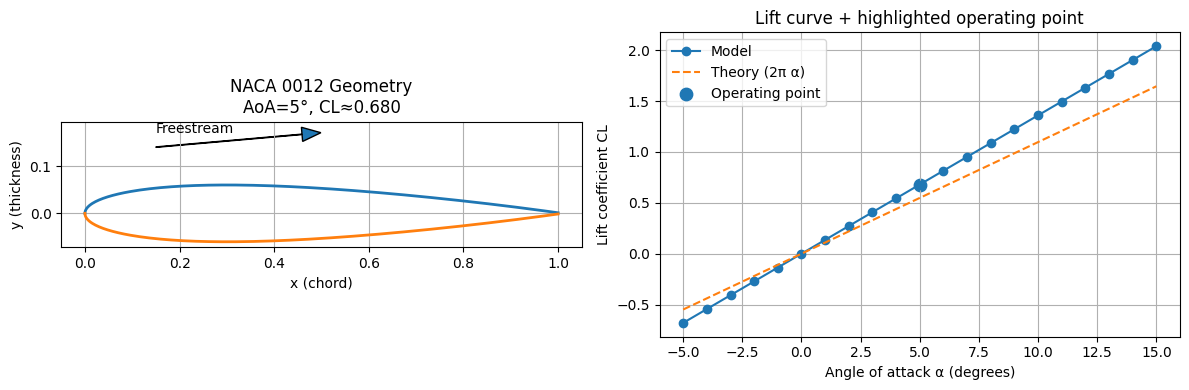

In [ ]:
# pick operating point
alpha_op = 5
Cpu, Cpl = Cp_distribution_low_fidelity(x, alpha_op)
CL_op = CL_from_pressure(x, Cpu, Cpl)

# geometry for left plot
x_u, y_u, x_l, y_l = naca0012_coordinates(n_points=200)

fig = plt.figure(figsize=(12, 4))

# Left: airfoil + AoA arrow
ax1 = plt.subplot(1, 2, 1)
ax1.plot(x_u, y_u, linewidth=2)
ax1.plot(x_l, y_l, linewidth=2)
ax1.set_aspect("equal", "box")
ax1.grid(True)
ax1.set_xlabel("x (chord)")
ax1.set_ylabel("y (thickness)")
ax1.set_title(f"NACA 0012 Geometry\nAoA={alpha_op}°, CL≈{CL_op:.3f}")

# AoA arrow
alpha_rad = np.deg2rad(alpha_op)
ax1.arrow(0.15, 0.14, 0.35*np.cos(alpha_rad), 0.35*np.sin(alpha_rad),
          head_width=0.03, head_length=0.04, length_includes_head=True)
ax1.text(0.15, 0.17, "Freestream", fontsize=10)

# Right: lift curve + highlight point
ax2 = plt.subplot(1, 2, 2)
ax2.plot(alphas, CL_model, marker="o", label="Model")
ax2.plot(alphas, CL_theory_curve, linestyle="--", label="Theory (2π α)")
ax2.scatter([alpha_op], [CL_op], s=80, label="Operating point")
ax2.set_xlabel("Angle of attack α (degrees)")
ax2.set_ylabel("Lift coefficient CL")
ax2.set_title("Lift curve + highlighted operating point")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()